In [10]:
#-------------------基础工具------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import time
import os
#------------------sklearn-------------------------------
from sklearn.cluster import k_means
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.manifold import t_sne
import  sklearn.learning_curve 
from sklearn.tree import DecisionTreeClassifier

#------------------keras --------------------------------
from keras.utils import plot_model
from keras.layers import Dropout
import keras 
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPool2D

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras import Sequential


#-----------------xgboost----------------------------

import xgboost as xgb

#---------------------参数设置----------------------------
%matplotlib inline
#CPU还是GPU
import copy
namespace='原始特征抽样_局部概率'
name_path='原始特征抽样_局部概率/'

In [11]:
def calc_kappa(y_true,y_pre):
    p0=0
    pe=0
    confux_m=confusion_matrix(y_true,y_pre)
    confux_m_sum=confux_m.sum()
    for i in range(len(confux_m)):
        p0+=confux_m[i][i]
        pe+=((confux_m[:,i]).sum())*((confux_m[i,:]).sum())
    p0=p0/confux_m_sum
    pe=pe/(confux_m_sum*confux_m_sum)
    kappa=(p0-pe)/(1-pe)
    return kappa

In [12]:
def conv_custom_1(data,columns,kernel,op='arg'):
    label_img=data['type'].values.reshape(256,108)
    for col in columns:
        var_img=data[col].values.reshape(256,108)
        con_var_img=np.zeros((258,110))
        con_label_img=np.ndarray(shape=(258,110),dtype=np.int32)
        con_label_img[:,:]=-1
        con_re=np.zeros((256,108))
        for i in range(256):
            for j in range(108):
                con_var_img[i+1][j+1]=var_img[i][j]
                con_label_img[i+1][j+1]=label_img[i][j]
        for i in range(1,257):
            for j in range(1,109):
                center=con_label_img[i][j]
                label_map=con_label_img[i-1:i+2,j-1:j+2]
                label_filter=(label_map==center)
                
                if op=='arg':
                    con_re[i-1][j-1]=con_var_img[i-1:i+2,j-1:j+2][label_filter].mean()
                elif op=='var':
                    con_re[i-1][j-1]=con_var_img[i-1:i+2,j-1:j+2][label_filter].var()
        if op=='arg':
            data[col+'_arg']=con_re.flatten()
        elif op=='var':
            data[col+'_var']=con_re.flatten()

In [13]:

def conv_(data,columns,kernel):
    for col in columns:
        var_img=data[col].values.reshape(256,108)
        data[col+'_arg']=scipy.signal.convolve2d(var_img,kernel,mode='same').flatten()

In [14]:
clf_name='1'
os.mkdir(name_path+clf_name)

In [15]:
def output(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,y_true,y_pre,y_fit_pre,clf_name):


    if  not (os.path.exists(name_path+clf_name)):

        os.mkdir(name_path+clf_name)


    pipline_fit_score['accuracy'].append(accuracy_score(y_true,y_fit_pre))

    pipline_test_score['accuracy'].append(accuracy_score(y_true,y_pre))

    kappas_['kappa'].append(calc_kappa(y_true,y_pre))

    pipline_fit_test_score['fit-accuracy'].append(accuracy_score(y_true,y_fit_pre))

    pipline_fit_test_score['test-accuracy'].append(accuracy_score(y_true,y_pre))

    pd.DataFrame(confusion_matrix(y_true,y_pre),index=range(1,17),columns=range(1,17)).to_csv(name_path+clf_name+'/'+clf_name+'_confux_matrix.csv')  

    Salinas_df5_raw[y_true!=y_pre][['row','col']].to_csv(name_path+clf_name+'/'+clf_name+'false_loc.csv',index=None,columns=None)

    Salinas_df5_raw['pre_type']=y_pre
    
    #np.savetxt(clf_name+'_pre_label.grd', y_pre.reshape(256,108),fmt='%d')

    Salinas_df5_raw[['row','col','pre_type']].to_csv( name_path+clf_name+'/'+clf_name+'_pre.csv')


In [16]:
def ouput2(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,clf_names):
    
    if not (os.path.exists(name_path+'统计量')):
        
        os.mkdir(name_path+'统计量')
    
    print('正在输出分类器准确率')

    pd.DataFrame(pipline_fit_score,index=clf_names).sort_values(by='accuracy').to_csv(name_path+'统计量/'+clf_name+'fit_accuracy.csv')
    pd.DataFrame(pipline_test_score,index=clf_names).sort_values(by='accuracy').to_csv(name_path+'统计量/'+clf_name+'test_accuracy.csv')
    pd.DataFrame(pipline_fit_test_score,index=clf_names).to_csv(name_path+'统计量/'+clf_name+'fit_test_accuracy.csv')

    print('正在输出kappa系数')

    pd.DataFrame(kappas_,index=clf_names).sort_values(by='kappa').to_csv(name_path+'统计量/'+clf_name+'kappa.csv')

数据的导入，切分，标准化

训练集维度： (27648, 27) 训练集变量: ['V4', 'V12', 'V20', 'V28', 'V36', 'V44', 'V52', 'V60', 'V68', 'V76', 'V84', 'V92', 'V100', 'V108', 'V116', 'V124', 'V132', 'V140', 'V148', 'V156', 'V164', 'V172', 'V180', 'V188']
测试集维度： (27648, 27) 测试集变量: ['V5', 'V13', 'V21', 'V29', 'V37', 'V45', 'V53', 'V61', 'V69', 'V77', 'V85', 'V93', 'V101', 'V109', 'V117', 'V125', 'V133', 'V141', 'V149', 'V157', 'V165', 'V173', 'V181', 'V189']
1 V4
1 V12
1 V20
1 V28
1 V36
1 V44
1 V52
1 V60
1 V68
1 V76
1 V84
1 V92
1 V100
1 V108
1 V116
1 V124
1 V132
1 V140
1 V148
1 V156
1 V164
1 V172
1 V180
1 V188
1 V5
1 V13
1 V21
1 V29
1 V37
1 V45
1 V53
1 V61
1 V69
1 V77
1 V85
1 V93
1 V101
1 V109
1 V117
1 V125
1 V133
1 V141
1 V149
1 V157
1 V165
1 V173
1 V181
1 V189
2 V4
2 V12
2 V20
2 V28
2 V36
2 V44
2 V52
2 V60
2 V68
2 V76
2 V84
2 V92
2 V100
2 V108
2 V116
2 V124
2 V132
2 V140
2 V148
2 V156
2 V164
2 V172
2 V180
2 V188
2 V5
2 V13
2 V21
2 V29
2 V37
2 V45
2 V53
2 V61
2 V69
2 V77
2 V85
2 V93
2 V101
2 V109
2 V117
2 V125
2 V133
2 V141
2 V149
2 V

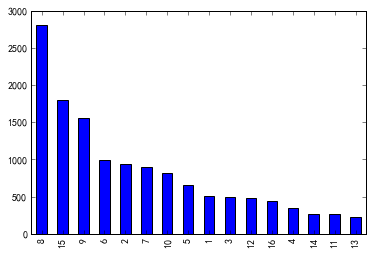

In [17]:
Salinas_df4_raw=pd.read_csv('Salinas_bandselect/SalinasResize_FCwithRC_No_4.txt',delimiter='\t',index_col=False)
Salinas_df5_raw=pd.read_csv('Salinas_bandselect/SalinasResize_FCwithRC_No_5.txt',delimiter='\t',index_col=False)
df4_columns=Salinas_df4_raw.columns[2:-1].tolist()
df5_columns=Salinas_df5_raw.columns[2:-1].tolist()
print('训练集维度：',Salinas_df4_raw.shape,'训练集变量:',df4_columns)
print('测试集维度：',Salinas_df5_raw.shape,'测试集变量:',df5_columns)

#---------------------------------------------------------
label_img=np.ndarray(shape=(258,110),dtype=np.int32)
label_img[:,:]=-1
type_m=Salinas_df4_raw.type.reshape(256,108)
label_img[1:257,1:109]=type_m

for k in range(1,17):
    
    type_prob_m=(label_img==k).astype('int32')/9

    for col in df4_columns:
        print(k,col)
        con_var_img=np.zeros((258,110))
        con_var_img[1:257,1:109]=Salinas_df4_raw[col].reshape(256,108)
        con_re=np.zeros((256,108))
        for i in range(1,257):
            for j in range(1,109):
                con_re[i-1][j-1]=(con_var_img[i-1:i+2,j-1:j+2]*type_prob_m[i-1:i+2,j-1:j+2]).sum()
        
        Salinas_df4_raw[col+'_'+str(k)+'_prob']=con_re.flatten()
        
    for col in df5_columns:
        print(k,col)

        con_var_img=np.zeros((258,110))
        con_var_img[1:257,1:109]=Salinas_df5_raw[col].reshape(256,108)
        con_re=np.zeros((256,108))
        for i in range(1,257):
            for j in range(1,109):
                con_re[i-1][j-1]=(con_var_img[i-1:i+2,j-1:j+2]*type_prob_m[i-1:i+2,j-1:j+2]).sum()
        
        Salinas_df5_raw[col+'_'+str(k)+'_prob']=con_re.flatten()
#----------------------------------------------------------



Salinas_df4_raw=Salinas_df4_raw[Salinas_df4_raw.type!=0]
Salinas_df5_raw=Salinas_df5_raw[Salinas_df5_raw.type!=0]
Salinas_df4=copy.deepcopy(Salinas_df4_raw)
Salinas_df5=copy.deepcopy(Salinas_df5_raw)
std=StandardScaler()
Salinas_df4.pop('row')
Salinas_df4.pop('col')
y_train=Salinas_df4.pop('type')
x_train=Salinas_df4
x_train=std.fit_transform(x_train)
Salinas_df5.pop('row')
Salinas_df5.pop('col')
y_test=Salinas_df5.pop('type')
x_test=Salinas_df5
x_test=std.fit_transform(x_test)
y_true=y_test
y_train.value_counts().plot(kind='bar')

In [18]:
if not (os.path.exists(namespace)):
    os.mkdir(namespace)

piplines=[LogisticRegression(),GradientBoostingClassifier(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier(),SVC()]
pipline_fit_score={'accuracy':[]}
pipline_test_score={'accuracy':[]}
pipline_fit_test_score={'fit-accuracy':[],'test-accuracy':[]}
kappas_={'kappa':[]}

clf_names=['逻辑回归','梯度提升决策树','随机森林','决策树','K-临近','SVM']

for clf_name,clf in zip(clf_names,piplines):
    
    
    clf.fit(x_train,y_train)
    
    print('拟合',clf_name,clf.score(x_train,y_train))
    
    print('测试',clf_name,clf.score(x_test,y_test))
    
    y_fit_pre=clf.predict(x_train)

    y_pre=clf.predict(x_test)
    
    output(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,y_true,y_pre,y_fit_pre,clf_name)

ouput2(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,clf_names)

拟合 逻辑回归 1.0
测试 逻辑回归 1.0
拟合 梯度提升决策树 1.0
测试 梯度提升决策树 1.0
拟合 随机森林 1.0
测试 随机森林 1.0
拟合 决策树 1.0
测试 决策树 1.0
拟合 K-临近 1.0
测试 K-临近 1.0
拟合 SVM 1.0
测试 SVM 1.0
正在输出分类器准确率
正在输出kappa系数


In [19]:
xgb_data_train=xgb.DMatrix(x_train,label=y_train)
xgb_data_test=xgb.DMatrix(x_test,label=y_test)
params={'max_depth':10,'eta':0.1,'silent':0,'objective':'multi:softmax','num_class':17,'alpha':0.5}
bst=xgb.train(params, 
          xgb_data_train, 
          num_boost_round=400, 
          evals=[(xgb_data_train,'train'),(xgb_data_test,'test')], 
          obj=None, 
          feval=None, 
          maximize=False, 
          early_stopping_rounds=None,
          evals_result=None,
          verbose_eval=100,
          xgb_model=None,
          callbacks=None)
xgb_data_test=xgb.DMatrix(x_test)
y_pre=bst.predict(xgb_data_test)
y_true=y_test

y_pre=bst.predict(xgb_data_test)
y_fit_pre=bst.predict(xgb_data_train)
y_true=y_test
accuracy_score(y_true,y_pre)


[0]	train-merror:0	test-merror:0
[100]	train-merror:0	test-merror:0
[200]	train-merror:0	test-merror:0
[300]	train-merror:0	test-merror:0
[399]	train-merror:0	test-merror:0


1.0

In [20]:
clf_name='XGBoost'
clf_names.append(clf_name)
output(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,y_true,y_pre,y_fit_pre,clf_name)
ouput2(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,clf_names)

正在输出分类器准确率
正在输出kappa系数


In [21]:
i=6
input_dim=x_train.shape[1]
output_dim=len(set(y_train.tolist()))
batch_size=16
lr=0.1
epochs=50
hidden_num = input_dim*i
hidden_num_2 = output_dim*i
ohe = OneHotEncoder()
y_train=ohe.fit_transform(np.matrix(y_train.values).T).toarray()
model=Sequential()
model.add(Dense(input_dim=input_dim,units=hidden_num))
model.add(Activation('relu'))
model.add(Dense(input_dim=hidden_num_2,units=output_dim))
optimizer=SGD(lr=lr)
model.compile(loss='mean_squared_error',optimizer=optimizer)
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)

y_pre=model.predict_classes(x_test, batch_size=batch_size)
y_fit_pre=model.predict_classes(x_train, batch_size=batch_size)

y_true=y_test
y_pre=y_pre+1
y_fit_pre=y_fit_pre+1


Epoch 1/50
13490/13490 [==============================] - 6s 411us/step - loss: 0.0250
Epoch 2/50
13490/13490 [==============================] - 2s 170us/step - loss: 6.4295e-04
Epoch 3/50
13490/13490 [==============================] - 2s 167us/step - loss: 3.6610e-04
Epoch 4/50
13490/13490 [==============================] - 2s 170us/step - loss: 2.5258e-04
Epoch 5/50
13490/13490 [==============================] - 2s 172us/step - loss: 1.9845e-04
Epoch 6/50
13490/13490 [==============================] - 2s 170us/step - loss: 1.6840e-04
Epoch 7/50
13490/13490 [==============================] - 2s 169us/step - loss: 1.3947e-04
Epoch 8/50
13490/13490 [==============================] - 2s 171us/step - loss: 1.2943e-04
Epoch 9/50
13490/13490 [==============================] - 2s 168us/step - loss: 1.4705e-04
Epoch 10/50
13490/13490 [==============================] - 2s 173us/step - loss: 1.2092e-04
Epoch 11/50
13490/13490 [==============================] - 2s 172us/step - loss: 1.0008e-04
E

In [22]:
clf_name='NN'
clf_names.append(clf_name)
output(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,y_true,y_pre,y_fit_pre,clf_name)
ouput2(pipline_fit_score,pipline_test_score,pipline_fit_test_score,kappas_,clf_names)

正在输出分类器准确率
正在输出kappa系数


# 输出部分

交叉矩阵(准确率、召回率,F1)

kappa系数
准确率
kappa计算结果为-1~1，但通常kappa是落在 0~1 间，可分为五组来表示不同级别的一致性：
0.0~0.20极低的一致性(slight)、
0.21~0.40一般的一致性(fair)、
0.41~0.60 中等的一致性(moderate)、
0.61~0.80 高度的一致性(substantial)
0.81~1几乎完全一致(almost perfect)。


losss下降过程(运算时间)

错的点的坐标

预测值的输出

神经网络层数图片

学习曲线